<a href="https://colab.research.google.com/github/bdip635/Histopathology-Classification/blob/main/LiverNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torchsummary import summary
from tqdm import tqdm
from torch.cuda.amp.grad_scaler import GradScaler

import matplotlib.pyplot as plt
import numpy as np
import os
import math
import cv2
from sklearn.metrics import ConfusionMatrixDisplay as CMD
from sklearn.metrics import confusion_matrix as CMT

In [2]:
!pip install pkbar
import pkbar

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
batch_size = 8
param = 128
device = 'cuda'
num_classes = 4
input_shape = (3,224,224)
scaler= GradScaler()

In [5]:
main_path = 'drive/My Drive/Course Project Image Processing - Histopathology/KMC Dataset'
work_path = 'drive/My Drive/Course Project Image Processing - Histopathology/db_dir'
train_dir= os.path.join(main_path,'Training')
test_dir= os.path.join(main_path,'Test')
val_dir= os.path.join(main_path,'Validation')

check_pt_file= os.path.join(work_path, 'LiverNet1_1.pth.tar')

print(os.listdir(train_dir))
print(os.listdir(test_dir))
print(os.listdir(val_dir))

['grade1', 'grade3', 'grade2', 'grade0']
['grade1', 'grade0', 'grade2', 'grade3']
['grade2', 'grade1', 'grade0', 'grade3']


In [6]:
my_transforms = transforms.Compose([ #Compose makes it possible to have many transforms
    transforms.ColorJitter(brightness=0.3, contrast=0.3), # Change brightness of image
    transforms.RandomRotation(degrees=15), # Perhaps a random rotation from -45 to 45 degrees
    transforms.RandomHorizontalFlip(p=0.5), # Flips the image horizontally with probability 0.5
    transforms.RandomVerticalFlip(p=0.05), # Flips image vertically with probability 0.05
    transforms.ToTensor() # Finally converts PIL image to tensor so we can train w. pytorch
    ])

In [7]:
train_data= datasets.ImageFolder(train_dir, transform= my_transforms)
test_data= datasets.ImageFolder(test_dir, transform= transforms.ToTensor())
val_data= datasets.ImageFolder(val_dir, transform= transforms.ToTensor())

In [8]:
train_loader= DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader= DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_loader= DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [9]:
class_dict=train_data.class_to_idx
print(class_dict)
class_labels = class_dict.values()
print(class_labels)

{'grade0': 0, 'grade1': 1, 'grade2': 2, 'grade3': 3}
dict_values([0, 1, 2, 3])


### Plotting the images with classes



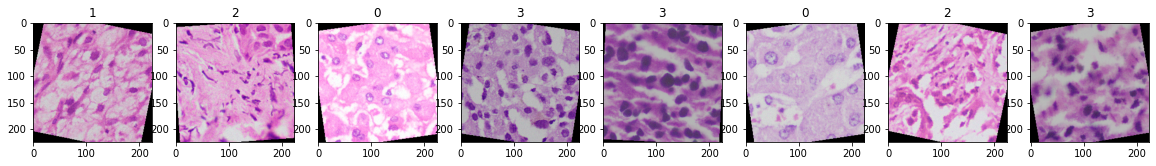

In [10]:
iterator= iter(train_loader)
it= next(iterator)
images, labels= it

plt.figure(figsize=(20,20))
for r in range(batch_size):
    plt.subplot(4,8,r+1)
    f= plt.imshow(images[r].permute(2,1,0))
    plt.title(labels[r].item())
plt.show()

#### Comparision Between Separable Convolutions and Straight Forward Convolution

In [11]:
class Separable_Conv_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1):
        super(Separable_Conv_Block, self).__init__()
        #At groups= in_channels, each input channel is convolved with its own set of filters.
        self.depth_wise_conv = nn.Conv2d(in_channels, in_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=in_channels)
        self.point_wise_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.depth_wise_conv(x)
        x = self.point_wise_conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [12]:
class Conv_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1):
        super(Conv_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [13]:
check_shape = (32,224,224)
S = Separable_Conv_Block(32, 100, 3).to(device)
C = Conv_Block(32, 100, 3).to(device)
summary(S, input_size=check_shape, device=device)
summary(C, input_size=check_shape, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             320
            Conv2d-2        [-1, 100, 222, 222]           3,300
       BatchNorm2d-3        [-1, 100, 222, 222]             200
              ReLU-4        [-1, 100, 222, 222]               0
Total params: 3,820
Trainable params: 3,820
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 6.12
Forward/backward pass size (MB): 124.83
Params size (MB): 0.01
Estimated Total Size (MB): 130.97
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 100, 222, 222]          28,900
       BatchNorm2d-2        [-1, 100, 222, 222]             200
              ReLU-3        [-1, 100, 222

In [34]:
class Residual_Block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample = None, stride=1):
    super(Residual_Block,self).__init__()
    self.expn = 1
    self.conv1 = Separable_Conv_Block(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(num_features=out_channels)

    self.conv2= Separable_Conv_Block(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn2= nn.BatchNorm2d(num_features=out_channels)

    self.conv3= Separable_Conv_Block(in_channels= out_channels, out_channels=out_channels*self.expn, kernel_size=1, stride=1, padding=0)
    self.bn3= nn.BatchNorm2d(num_features=out_channels*self.expn)
    self.relu= nn.ReLU()
    self.identity_downsample = identity_downsample

  def forward(self,x):

    identity = x.clone()
    x = nn.Sequential(self.conv1,
                     self.bn1,
                     self.relu,
                     self.conv2,
                     self.bn2,
                     self.relu,
                     self.conv3,
                     self.bn3)(x)
    if self.identity_downsample is not None:
      identity = self.identity_downsample(identity)
    x += identity
    x = self.relu(x)
    return x

In [35]:
class Classifier(nn.Module):
  def __init__(self, in_features, num_classes):
    super(Classifier, self).__init__()

    self.fc1=  nn.Sequential( nn.Linear(in_features, 256),
                              nn.BatchNorm1d(256),
                              nn.ReLU(),
                              nn.Dropout(p=0.3)
                            )
    self.fc2= nn.Linear(256, num_classes)
  
  def forward(self, x):
    x= x.reshape(x.shape[0],-1)
    return self.fc2(self.fc1(x))

In [36]:
class CBAM_Block(nn.Module):

  def __init__(self, in_features):
    super(CBAM_Block, self).__init__()

    self.avgpool= nn.AdaptiveAvgPool2d((1,1))
    self.maxpool= nn.AdaptiveMaxPool2d((1,1))
    self.fc= nn.Linear(in_features, in_features)
    self.conv= Separable_Conv_Block(in_channels=2*in_features, out_channels=1, kernel_size=3, padding=1)
    self.act= nn.Sigmoid()
  
  def forward(self, x):

    A1= self.avgpool(x)
    A1= A1.reshape(A1.shape[0], -1)
    A2= self.maxpool(x)
    A2= A2.reshape(A2.shape[0], -1)
    Ac= self.act(self.fc(A1))+self.fc(A2)
    Ac= torch.unsqueeze(torch.unsqueeze(Ac, 2), 3)*x

    concat= torch.cat((self.avgpool(Ac), self.maxpool(Ac)), dim=1)
    As= self.act(self.conv(concat))*Ac
    return As

In [37]:
class ASPP_Block(nn.Module):
  
  def __init__(self, in_channels, out_channels):
    super(ASPP_Block, self).__init__()

    self.conv1x1  = Separable_Conv_Block(in_channels, out_channels, kernel_size=1, stride=1)
    self.conv3x3_2= Separable_Conv_Block(in_channels, out_channels, kernel_size=3, stride=1, padding=2, dilation=2)
    self.conv3x3_3= Separable_Conv_Block(in_channels, out_channels, kernel_size=3, stride=1, padding=3, dilation=3)
    self.conv3x3_4= Separable_Conv_Block(in_channels, out_channels, kernel_size=3, stride=1, padding=4, dilation=4)
    self.conv3x3_6= Separable_Conv_Block(in_channels, out_channels, kernel_size=3, stride=1, padding=6, dilation=6)
    self.global_pool= nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2),
                                    Separable_Conv_Block(in_channels, out_channels, kernel_size=1),
                                    nn.UpsamplingBilinear2d(scale_factor=2))

  def forward(self, x):
    op1= self.conv1x1(x)
    op2= self.conv3x3_2(x)
    op3= self.conv3x3_3(x)
    op4= self.conv3x3_4(x)
    op5= self.conv3x3_6(x)
    op6= self.global_pool(x)

    return torch.cat((op1,op2,op3,op4,op5,op6), dim=1)

In [38]:
class LiverNet(nn.Module):

  def __init__(self, image_shape, num_classes):
    super(LiverNet, self).__init__()

    self.aspp_out_channels= param
    self.conv_block_1= Separable_Conv_Block(3, 32, kernel_size=3, padding=1)
    self.conv_block_2= Separable_Conv_Block(32, 32, kernel_size=3, padding=1)
    self.pool= nn.MaxPool2d(kernel_size=2, stride=2)
    self.global_avg_pool= nn.AdaptiveAvgPool2d((1,1))
    self.conv_block_3= Separable_Conv_Block(32, 64, kernel_size=3, padding=1)
    self.cbam= CBAM_Block(in_features=64)
    self.res_block= Residual_Block(in_channels=64,
                                     out_channels=64,
                                     identity_downsample = Separable_Conv_Block(64, 64, kernel_size=1))
    self.conv_block_4= Separable_Conv_Block(64, 64, kernel_size=3, padding=1)

    self.aspp_1= ASPP_Block(in_channels=32, out_channels=self.aspp_out_channels)
    self.aspp_2= ASPP_Block(in_channels=64, out_channels=self.aspp_out_channels)
    self.upsample_1= nn.UpsamplingBilinear2d(scale_factor=2)
    self.upsample_2= nn.UpsamplingBilinear2d(scale_factor=4)
    self.upsample_3= nn.UpsamplingBilinear2d(scale_factor=8)
    self.classifier= Classifier(in_features=self.aspp_out_channels*18, num_classes=num_classes)
    
  def forward(self, x):
    x1= self.conv_block_1(x)
    x1= self.conv_block_2(x1)
    x1 = self.pool(x1)

    x2= self.conv_block_3(x1)
    x2= self.cbam(x2)
    x2= self.res_block(x2)
    x2= self.pool(x2)

    x3= self.conv_block_4(x2)
    x3= self.cbam(x3)
    x3= self.res_block(x3)
    x3= self.pool(x3)

    a1= self.aspp_1(x1)
    a1= self.upsample_1(a1)

    a2= self.aspp_2(x2)
    a2= self.upsample_2(a2)

    a3= self.aspp_2(x3)
    a3= self.upsample_3(a3)

    out= torch.cat((a1,a2,a3), dim=1)
    out= self.global_avg_pool(out)
    out= self.classifier(out)

    return out

In [39]:
model= LiverNet(input_shape, num_classes).to(device)
summary(model, input_size= input_shape, batch_size=batch_size, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [8, 3, 224, 224]              30
            Conv2d-2          [8, 32, 224, 224]             128
       BatchNorm2d-3          [8, 32, 224, 224]              64
              ReLU-4          [8, 32, 224, 224]               0
Separable_Conv_Block-5          [8, 32, 224, 224]               0
            Conv2d-6          [8, 32, 224, 224]             320
            Conv2d-7          [8, 32, 224, 224]           1,056
       BatchNorm2d-8          [8, 32, 224, 224]              64
              ReLU-9          [8, 32, 224, 224]               0
Separable_Conv_Block-10          [8, 32, 224, 224]               0
        MaxPool2d-11          [8, 32, 112, 112]               0
           Conv2d-12          [8, 32, 112, 112]             320
           Conv2d-13          [8, 64, 112, 112]           2,112
      BatchNorm2d-14          [8, 

In [ ]:
learning_rate=1e-4
num_epochs= 100

In [ ]:
Loss= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def check_accuracy(scores, targets):

  num_correct=0
  num_samples=0
  _, predictions= scores.max(1)
  num_correct+= (predictions== targets).sum()
  num_samples= predictions.size(0)

  return num_correct/num_samples

In [ ]:
def save_checkpoint(model, optimizer, file_name):

  checkpoint= {'state_dict': model.state_dict(),
             'optimizer_dict': optimizer.state_dict()}
  torch.save(checkpoint,file_name)

def load_checkpoint(model, optimizer, file_name):
  check_pt= torch.load(file_name, map_location= torch.device(device))
  model.load_state_dict(check_pt['state_dict'])
  optimizer.load_state_dict(check_pt['optimizer_dict'])

  return model, optimizer

In [ ]:
### Training Loop


train_per_epoch= len(train_loader)
val_per_epoch= len(val_loader)
min_loss= math.inf



for epoch in range(num_epochs):
  train_losses=[]
### TRAINING

  kbar_train= pkbar.Kbar(target= train_per_epoch, epoch=epoch, num_epochs=num_epochs)

  train_loop= enumerate(train_loader)
  val_loop= enumerate(val_loader)
  for batch_idx, (data,targets) in train_loop:

    model.train()

    data= data.to(device=device)
    targets= targets.to(device=device)

    # FORWARD PROP

    scores= model(data)
    train_loss= Loss(scores, targets)
    train_losses.append(train_loss.item())

    # BACKWARD PROP
    optimizer.zero_grad()
    train_loss.backward()

    optimizer.step()

    train_acc= check_accuracy(scores,targets)

    kbar_train.update(batch_idx, values=[("loss", train_loss.item()), ("accuracy", train_acc.item())])

  kbar_train.update(train_per_epoch, values=None)
### VALIDATION

  kbar_val= pkbar.Kbar(target= val_per_epoch, epoch=epoch, num_epochs=num_epochs)


  for batch_idx, (data, targets) in val_loop:

    val_losses=[]
    model.eval()

    
    data= data.to(device=device)
    targets= targets.to(device=device)
    scores= model(data)
    val_loss= Loss(scores, targets)
    val_losses.append(val_loss.item())
    val_acc= check_accuracy(scores,targets)

    kbar_val.update(batch_idx, values=[("val_loss", val_loss.item()), ("val_accuracy", val_acc.item())])

  if np.mean(val_losses)<min_loss:
    min_loss= val_loss.item()
    print('\nImproved validation loss: {:.4f}'.format(val_loss.item()))
    print('Saving the model to {}\n'.format(check_pt_file))
    save_checkpoint(model, optimizer, check_pt_file)
    
  kbar_val.update(val_per_epoch, values=None)

Epoch: 1/100
662/662 [==============================] - 2165s 3s/step - loss: 0.3066 - accuracy: 0.8759
Epoch: 1/100
69/70 [============================>.] - ETA: 2s - val_loss: 0.2486 - val_accuracy: 0.9094
Improved validation loss: 0.3406
Saving the model to drive/My Drive/Hist_folder/KMC Dataset/LiverNet_256_2.pth.tar

70/70 [==============================] - 180s 3s/step - val_loss: 0.2486 - val_accuracy: 0.9094
Epoch: 2/100
662/662 [==============================] - 568s 859ms/step - loss: 0.3186 - accuracy: 0.8744
Epoch: 2/100
69/70 [============================>.] - ETA: 0s - val_loss: 0.2549 - val_accuracy: 0.8696
Improved validation loss: 0.0099
Saving the model to drive/My Drive/Hist_folder/KMC Dataset/LiverNet_256_2.pth.tar

70/70 [==============================] - 18s 252ms/step - val_loss: 0.2549 - val_accuracy: 0.8696
Epoch: 3/100
662/662 [==============================] - 569s 859ms/step - loss: 0.3085 - accuracy: 0.8748
Epoch: 3/100
70/70 [==============================

In [ ]:
def CONFUSION_MATRIX(y_true, y_pred, class_labels, order=False):
  
  num_classes= len(class_labels)
  num_examples= len(y_true)

  if order is False:
    new_labels= np.arange(num_classes)
    
    for i in range(num_examples):
      y_true[i].item= np.where(class_labels==y_true[i])[0]
      y_pred[i].item= np.where(class_labels==y_pred[i])[0]

  mat= np.zeros((num_classes,num_classes), dtype=np.int)
  
  for i in range(num_examples):
    true= np.uint8(y_true[i].item())
    pred= np.uint8(y_pred[i].item())

    mat[true,pred]+=1

  return mat


def acc_precision_recall_f1(confusion_matrix):

  num_classes= confusion_matrix.shape[0]
  precision=      np.zeros((num_classes,1), np.float32)
  recall=         np.zeros((num_classes,1), np.float32)
  true_positives= np.zeros((num_classes,1), np.float32)
  true_negatives= np.zeros((num_classes,1), np.float32)
  accuracy=       np.zeros((num_classes,1), np.float32)
  f1=             np.zeros((num_classes,1), np.float32)

  for i in range(num_classes):
    
    true_positives[i]= confusion_matrix[i,i]
    precision[i]= confusion_matrix[i,i]/np.sum(confusion_matrix[i])
    recall[i]= confusion_matrix[i,i]/np.sum(confusion_matrix[:,i])
    f1[i]= 2*precision[i]*recall[i]/(precision[i]+recall[i])
  

  for i in range(num_classes):
    true_negatives[i]=0
    for j in range(num_classes):
      for k in range(num_classes):
        if (j!=i) and (k!=i):
          true_negatives[i]+=confusion_matrix[j,k]

  accuracy= (true_positives+true_negatives)/np.sum(confusion_matrix)
  return accuracy, precision, recall, f1


def Final_Metrics(loader, model, class_labels):

    model.eval()
    size= len(class_labels)
    c_mat= np.zeros((size,size), dtype= np.int)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores= model(x)
            _, preds = scores.max(1)

            c_mat+= CONFUSION_MATRIX(y, preds, class_labels, order= True)
    
    accuracy, precision, recall, f1= acc_precision_recall_f1(c_mat)

    return c_mat, accuracy, precision, recall, f1

In [ ]:
liver_net, _= load_checkpoint(model, optimizer, check_pt_file)

In [ ]:
confusion_matrix, accuracy, precision, recall, f1= Final_Metrics(test_loader, liver_net, class_labels)

In [ ]:
print(confusion_matrix)

[[70  0  0  0]
 [ 3 62 15  0]
 [ 0  0 80  0]
 [ 0  0  3 47]]


In [ ]:
print(precision.T)
print(np.mean(precision))

print(recall.T)
print(np.mean(recall))

print(f1.T)
print(np.mean(f1))

print(accuracy.T)
print(np.mean(accuracy))

[[1.    0.775 1.    0.94 ]]
0.92875004
[[0.9589041  1.         0.81632656 1.        ]]
0.94380766
[[0.979021   0.8732394  0.89887637 0.96907216]]
0.9300522
[[0.9892857 0.9357143 0.9357143 0.9892857]]
0.9625


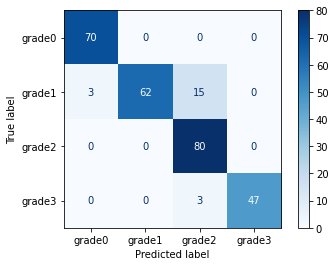

In [ ]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([], device=device)
    all_labels= torch.tensor([], device=device)
    for images,labels in loader:
        images= images.to(device)
        labels= labels.to(device)
        scores = model(images)
        _, preds= scores.max(1)
        all_preds = torch.cat((all_preds, preds),dim=0)
        all_labels = torch.cat((all_labels, labels),dim=0)
    return all_preds, all_labels

with torch.no_grad():
    all_preds, all_labels = get_all_preds(liver_net.to(device), test_loader)

cmt= CMT(all_labels.cpu(), all_preds.cpu())
# print(cmt)
# print()
# print(confusion_matrix)
names= sorted(os.listdir(test_dir))
disp= CMD(cmt, names)
disp.plot(cmap='Blues')